In [12]:
pip install wordcloud


    100% |████████████████████████████████| 368kB 169kB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pickle as pk
import pandas as pd
import numpy as np
import tweet_catch as tC
import matplotlib.pyplot as plt
import seaborn as sns
import ps_preprocess as pp
import warnings
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [55]:
df = pd.read_csv('spam.csv', sep=',', encoding='latin-1', usecols=lambda col: col not in ["Unnamed: 2","Unnamed: 3","Unnamed: 4"])

In [56]:
df.head(1)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."


In [57]:
df = df.rename(columns={"v1":"label", "v2":"text"})

In [58]:
df.head(5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [59]:
warnings.filterwarnings('ignore')

In [60]:
#Read dataset
tweets = df

In [61]:
print(tweets)

     label                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham              Will Ì_ b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [62]:
tweets['length'] = tweets['text'].apply(len)

In [63]:
print(tweets)

     label                                               text  length
0      ham  Go until jurong point, crazy.. Available only ...     111
1      ham                      Ok lar... Joking wif u oni...      29
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3      ham  U dun say so early hor... U c already then say...      49
4      ham  Nah I don't think he goes to usf, he lives aro...      61
...    ...                                                ...     ...
5567  spam  This is the 2nd time we have tried 2 contact u...     161
5568   ham              Will Ì_ b going to esplanade fr home?      37
5569   ham  Pity, * was in mood for that. So...any other s...      57
5570   ham  The guy did some bitching but I acted like i'd...     125
5571   ham                         Rofl. Its true to its name      26

[5572 rows x 3 columns]


In [64]:
#Showcase data
tweet_preview = tweets.tail(10)
tweet_group = tweets.groupby('label').describe()

In [65]:
print('*********** DATASET ***********')
print(tweet_preview)
print('\n------------------\n')
print('*********** DATASET GROUPED BY LABEL ***********')
print(tweet_group)
print('\n------------------\n')

*********** DATASET ***********
     label                                               text  length
5562   ham  Ok lor... Sony ericsson salesman... I ask shuh...      96
5563   ham                                Ard 6 like dat lor.      19
5564   ham  Why don't you wait 'til at least wednesday to ...      67
5565   ham                                       Huh y lei...      12
5566  spam  REMINDER FROM O2: To get 2.50 pounds free call...     147
5567  spam  This is the 2nd time we have tried 2 contact u...     161
5568   ham              Will Ì_ b going to esplanade fr home?      37
5569   ham  Pity, * was in mood for that. So...any other s...      57
5570   ham  The guy did some bitching but I acted like i'd...     125
5571   ham                         Rofl. Its true to its name      26

------------------

*********** DATASET GROUPED BY LABEL ***********
       length                                                         
        count        mean        std   min    25%    50% 

*********** SPAM WORD CLOUD ***********


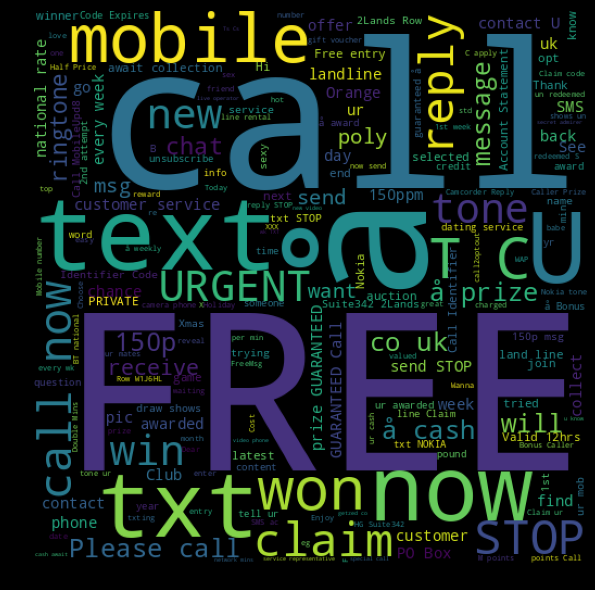


------------------



In [68]:
#Get number of tweets from the matris tweets and create offsets for training and testing purposes
totalTweets = tweets['text'].shape[0]
spam_words = ' '.join(list(tweets[tweets['label'] == 'spam']['text']))
spam_Vcloud = WordCloud(width = 512, height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_Vcloud)#plt.axis('off')
plt.tight_layout(pad = 0)
print('*********** SPAM WORD CLOUD ***********')
plt.show()
print('\n------------------\n')

trainOffset, testOffset = list(), list()

In [69]:
#Using random selection for separation with sensitivity of 0.8

for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.8:
        trainOffset += [i]
    else:
        testOffset += [i]

In [70]:
#Loading the training and testing data with the randomly selected location offsets
train_data = tweets.loc[trainOffset]
test_data = tweets.loc[testOffset]

In [71]:
#Showcase training data
train_data.reset_index(inplace = True)
train_data.drop(['index'], axis = 1, inplace = True)
train_preview = train_data.head(15)
print('*********** SHOWCASE OF TRAINING DATA ***********')
print(train_preview)
print('\n')

#Training data grouping by label
train_group = train_data['label'].value_counts()
print('*********** TRAINING DATA GROUPED BY LABEL ***********')
print(train_group)
print('\n------------------\n')

*********** SHOWCASE OF TRAINING DATA ***********
   label                                               text  length
0    ham  Go until jurong point, crazy.. Available only ...     111
1    ham                      Ok lar... Joking wif u oni...      29
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3    ham  Nah I don't think he goes to usf, he lives aro...      61
4   spam  FreeMsg Hey there darling it's been 3 week's n...     148
5    ham  Even my brother is not like to speak with me. ...      77
6    ham  As per your request 'Melle Melle (Oru Minnamin...     160
7   spam  WINNER!! As a valued network customer you have...     158
8   spam  Had your mobile 11 months or more? U R entitle...     154
9   spam  SIX chances to win CASH! From 100 to 20,000 po...     136
10   ham  I've been searching for the right words to tha...     196
11   ham                I HAVE A DATE ON SUNDAY WITH WILL!!      35
12  spam  XXXMobileMovieClub: To use your credit, click ...     14

In [72]:
tweetFeatures = tweets['text'].copy()
tweetFeatures = tweetFeatures.apply(pp.snowball_process)
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(tweetFeatures)

features_train, features_test, labels_train, labels_test = train_test_split(features, tweets['label'], test_size=0.4, random_state=111)

In [100]:
alg_name = []
alg_accuracies = []
alg_f1 = []

mnb = MultinomialNB(alpha=0.2)
mnb.fit(features_train, labels_train)
prediction = mnb.predict(features_test)
conf_mat = metrics.confusion_matrix(labels_test, prediction)
print('MULTINOMIAL NAIVE BAYES SCORE:', accuracy_score(labels_test, prediction))
alg_name.append('Multinomial Naive Bayes')
alg_accuracies.append(mnb.score(features_test, labels_test) * 100)

bnb = BernoulliNB()
bnb.fit(features_train, labels_train)
pred_bnb = bnb.predict(features_test)
conf_mat_bnb = metrics.confusion_matrix(labels_test, pred_bnb)
print('BERNOULLI NAIVE BAYES SCORE:', accuracy_score(labels_test,pred_bnb))
alg_name.append('Bernoulli Naive Bayes')
alg_accuracies.append(bnb.score(features_test, labels_test) * 100)

svc = SVC(gamma="scale")
svc.fit(features_train, labels_train)
pred_svc = svc.predict(features_test)
conf_mat_svc = metrics.confusion_matrix(labels_test, pred_svc)
print('SUPPORT VECTOR MACHINE SCORE:', accuracy_score(labels_test, pred_svc))
alg_name.append('Support Vector Machine')
alg_accuracies.append(svc.score(features_test, labels_test) * 100)

MULTINOMIAL NAIVE BAYES SCORE: 0.9883408071748879
BERNOULLI NAIVE BAYES SCORE: 0.9802690582959641
SUPPORT VECTOR MACHINE SCORE: 0.9757847533632287


In [101]:
print("\nMNB Classifier accuracy {:.2f}%".format(mnb.score(features_test, labels_test) * 100))
print("BNB Classifier accuracy {:.2f}%".format(bnb.score(features_test, labels_test) * 100))
print("SVC Classifier accuracy {:.2f}%".format(svc.score(features_test, labels_test) * 100))


MNB Classifier accuracy 98.83%
BNB Classifier accuracy 98.03%
SVC Classifier accuracy 97.58%


In [102]:
mnb_fscore = metrics.f1_score(labels_test, prediction, average='macro')
print("\nMNB F1 score is: {:.2f}".format(mnb_fscore))
alg_f1.append(mnb_fscore)

bnb_fscore = metrics.f1_score(labels_test, pred_bnb, average='macro')
print("BNB F1 score is: {:.2f}".format(bnb_fscore))
alg_f1.append(bnb_fscore)

svc_fscore = metrics.f1_score(labels_test, pred_svc, average='weighted')
print("SVC F1 score is: {:.2f}".format(svc_fscore))
alg_f1.append(svc_fscore)


MNB F1 score is: 0.97
BNB F1 score is: 0.96
SVC F1 score is: 0.97


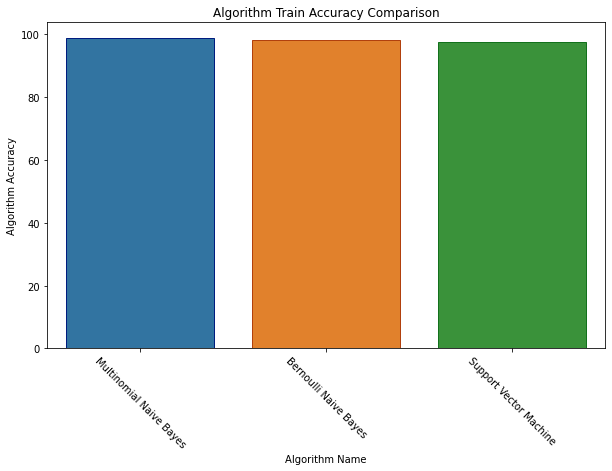

In [103]:
data = pd.DataFrame({'alg_name': alg_name, 'alg_accuracies': alg_accuracies})
sorted_data = data.reindex((data['alg_accuracies'].sort_values(ascending=False)).index.values)

plt.subplots(figsize=(10,6))
sns.barplot(x=sorted_data['alg_name'], y=sorted_data['alg_accuracies'], edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=-45)
plt.xlabel('Algorithm Name')
plt.ylabel('Algorithm Accuracy')
plt.title('Algorithm Train Accuracy Comparison')
plt.show()

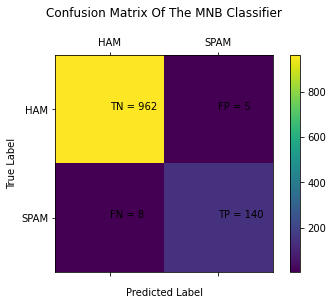

In [104]:
#Confusion Matrix For MNB
labels = ['HAM', 'SPAM']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
plt.title('Confusion Matrix Of The MNB Classifier\n')
fig.colorbar(cax)
tick_marks = np.arange(len(labels))
plt.xlabel('\nPredicted Label')
plt.ylabel('True Label')
plt.xticks(tick_marks, labels, rotation=0)
plt.yticks(tick_marks, labels)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(conf_mat[i][j]))
plt.show()

In [110]:
print("\n*********** TEST PHASE WITH LIVE TWEET ***********\n")

twitter_client = tC.TwitterClient()
tweets = twitter_client.get_live_feed(1)
tweetList = []
tweetList.append(tweets[0].text)
#tweetList.append('free mobile phone. click below link')
accused_user = tweets[0].user.screen_name
input_transformed = vectorizer.transform(tweetList)
prediction = mnb.predict(input_transformed)

print('Analyzed live-tweet:', tweetList)
print('By user: @'+ accused_user)
print('\nAccording to MNB Classification this tweet is', 'HAM' if prediction == 'ham' else 'SPAM')


*********** TEST PHASE WITH LIVE TWEET ***********

Analyzed live-tweet: ["BREAKING : Prince Philip's Spotify history reveals his last played song was Bye Bye Baby (Taylor's Version)"]
By user: @donpenguinii

According to MNB Classification this tweet is HAM
